In [115]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial
#import seaborn as sn
from sklearn.model_selection import train_test_split

from random import seed
seed(1)
seed = 43

import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from tensorflow import core
from tensorflow.keras import layers
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ",keras.__version__)


kaggle = 0 # Kaggle path active = 1

# change your local path here
if kaggle == 1 :
    MNIST_PATH= '../input/digit-recognizer'
else:
    MNIST_PATH= '../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer'



import os
for dirname, _, filenames in os.walk(MNIST_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version:  2.3.0
Keras Version:  2.4.0
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\keras_reg_160_10_002.sav
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\keras_reg_jl_160_10_002.sav
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\sample_submission.csv
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\test.csv
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\train.csv


# Introduction - MNIST Training Competition
This notebook is a fork or copy of my previous developed notebook for digit recognition. Therefore you will find some parts that look common to the notebook <a href="https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network">Digit Recognition with a Deep Neural Network</a> or <a href="https://www.kaggle.com/skiplik/finetuning-hyperparameters-in-deep-neural-network">Finetuning Hyperparameters in Deep Neural Network</a>.


Link to the data topic: https://www.kaggle.com/c/digit-recognizer/data

As in the previous notebooks I will use Tensorflow with Keras. I already mentioned in other notebooks, I will skip some explanations about the data set here. Moreover I will use the already discovered knowledge about the data and transform/prepare the data rightaway.

The current best run was based on the Version 7 with an accuracy of 0.97657 on the kaggle competition "Digit Recognzier"


## My other Projects
If you are interested in some more clearly analysis of the dataset take a look into my other notebooks about the MNIS-dataset:
- Finetuning Hyperparameters in Deep Neural Network:
    - https://www.kaggle.com/skiplik/finetuning-hyperparameters-in-deep-neural-network
- Digit Recognition with a Deep Neural Network: 
    - https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network
- Another MNIST Try:
    - https://www.kaggle.com/skiplik/another-mnist-try
- First NN by Detecting Handwritten Characters:
    - https://www.kaggle.com/skiplik/first-nn-by-detecting-handwritten-characters
...




# Get Data

In [116]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_mnist_data(minist_path, csv_file):
    csv_path = os.path.join(minist_path, csv_file)
    return pd.read_csv(csv_path)

def load_mnist_data_manuel(minist_path, csv_file):
    csv_path = os.path.join(minist_path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data

def split_train_val(data, val_ratio):
    return 
    

train = load_mnist_data(MNIST_PATH,CSV_FILE_TRAIN)
test = load_mnist_data(MNIST_PATH,CSV_FILE_TEST)

In [117]:
y = train['label'].copy()
X = train.drop(['label'], axis=1)

# competition dataset
X_test = test.copy()

## Train / Val Split

In [118]:
print("Shape of the Features: ",X.shape)
print("Shape of the Labels: ", y.shape)

Shape of the Features:  (42000, 784)
Shape of the Labels:  (42000,)


### Label Value Count
Visualizing the label distribution of the full train dataset.

In [119]:
train.value_counts('label')

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
dtype: int64

In [120]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.20
                                                  , stratify=y
                                                 )

Comparing the equally splitted train- and val-sets based on the given label y.

In [121]:
print("Train - Set Distribution")
print(y_train.value_counts() / y_train.value_counts().sum() )
print('--------------------------------------------------------------')
print('--------------------------------------------------------------')
print('--------------------------------------------------------------')
print("Val - Set Distribution")
print(y_val.value_counts() / y_val.value_counts().sum() )


Train - Set Distribution
1    0.111518
7    0.104792
3    0.103601
9    0.099702
2    0.099464
6    0.098512
0    0.098363
4    0.096964
8    0.096726
5    0.090357
Name: label, dtype: float64
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
Val - Set Distribution
1    0.111548
7    0.104762
3    0.103571
9    0.099762
2    0.099405
0    0.098452
6    0.098452
4    0.096905
8    0.096786
5    0.090357
Name: label, dtype: float64


In [122]:
print("X: ", X.shape)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)

print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)

X:  (42000, 784)
X_train:  (33600, 784)
X_val:  (8400, 784)
y_train:  (33600,)
y_val:  (8400,)


## Building Transforming Piplines

In [123]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    #('normalizer', Normalizer())
    ('std_scalar',StandardScaler())
])

## Preprocessing Data

### Data Augmentation with Tensorflow Data Api

In [124]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 85 // 100       # croping to 90% of the initial picture 
    return tf.image.random_crop(image, [min_dim, min_dim, 1])


def crop_flip_resize(image, label, flipping = True):
    if flipping == True:
        cropped_image = random_crop(image)
        cropped_image = tf.image.flip_left_right(cropped_image)
    else:
        cropped_image = random_crop(image)

    ## final solution
    resized_image = tf.image.resize(cropped_image, [28,28])
    final_image = resized_image
    #final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label  
    

In [125]:
X_val.shape

(8400, 784)

In [126]:
# converting dataframe format into tensorflow compatible format.
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.values.reshape(X_val.shape[0], 28, 28, 1)

X_train_crop = X_train.copy()
X_val_crop = X_val.copy()

In [127]:
# Creating tensorbased dataset 

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train, tf.float32),
            tf.cast(y_train, tf.int32)
        )
    )
)


val_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
             tf.cast(X_val, tf.float32),
             tf.cast(y_val, tf.int32)
        )
    )
)


training_crop_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train_crop, tf.float32),
            tf.cast(y_train, tf.int32)
        )
    )
)


val_crop_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
             tf.cast(X_val_crop, tf.float32),
             tf.cast(y_val, tf.int32)
        )
    )
)


In [128]:
# resizing, croping images via self build function
training_crop_dataset = training_crop_dataset.map(partial(crop_flip_resize, flipping=False))
val_crop_dataset = val_crop_dataset.map(partial(crop_flip_resize, flipping=False))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


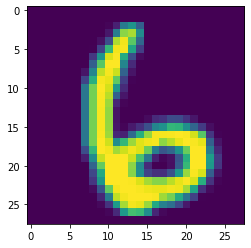

In [129]:
# Visualizing a croped, flipped, resized image from new dataset.
for X_values, y_values in training_crop_dataset.take(1):
    for index in range(1):
        plt.imshow(X_values)

In [130]:
# concate the two datasets
training_dataset_all = training_dataset.concatenate(training_crop_dataset)
val_dataset_all = val_dataset.concatenate(val_crop_dataset)

In [131]:
print("training_dataset_all length: ", len(list(training_dataset_all)))
print("val_dataset_all length: ", len(list(val_dataset_all)))


training_dataset_all length:  67200
val_dataset_all length:  16800


In [132]:
# shuffeling and batching data
tf.random.set_seed(seed)

train_ds = training_dataset_all.shuffle(10000).batch(32).prefetch(1)
val_ds = val_dataset_all.shuffle(8000).batch(32).prefetch(1)

# Building a Deep Neural Network

## Preparing Model Visualization with Tensorboard (not for Kaggle)

In [133]:
root_logdir = "../../tensorboard-logs"

print("Relative root_logdir: ",root_logdir)

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)

Relative root_logdir:  ../../tensorboard-logs


In [134]:
run_logdir = get_run_logdir()
print("Current run logdir for Tensorboard: ", run_logdir)

Current run logdir for Tensorboard:  ../../tensorboard-logs\run_2021_11_12-17_24_34


In [135]:
run_logdir

'../../tensorboard-logs\\run_2021_11_12-17_24_34'

### Keras Callbacks for Tensorboard
With Keras there is a way of using Callbacks for the Tensorboard to write log files for the board and visualize the different graphs (loss and val curve)


In [136]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Building Model Architecture

In [137]:
from keras.layers import LeakyReLU

input_shape=[784]
input_shape_notFlattened=[28,28,1]

batch_shape = []


learning_rt = 1e-03 
activation_fn = "relu"
initializer = "he_normal"
regularizer =  None

# Model building
def create_model_struc():  
    model = keras.models.Sequential()

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', input_shape=input_shape_notFlattened))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(activation_fn))
    model.add(keras.layers.MaxPooling2D(2))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(activation_fn))
    model.add(keras.layers.MaxPooling2D(2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation="softmax"))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rt)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'] )
    model.build()

    return model   


In [138]:
model = create_model_struc()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
activation_16 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_17 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
activation_17 (Activation)   (None, 4, 4, 128)        

## Model Checkpoints

In [139]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_train_model.h5", save_best_only=True, save_weights_only=False)

## Model Training

In [140]:
history = model.fit(train_ds, epochs=14, validation_data=val_ds, callbacks=[checkpoint_cb, keras.callbacks.EarlyStopping(patience=20), tensorboard_cb])

Epoch 1/14
2100/2100 [==============================] - 22s 11ms/step - loss: 0.1973 - accuracy: 0.9401 - val_loss: 0.1185 - val_accuracy: 0.9623
Epoch 2/14
2100/2100 [==============================] - 22s 10ms/step - loss: 0.0882 - accuracy: 0.9722 - val_loss: 0.0991 - val_accuracy: 0.9709
Epoch 3/14
2100/2100 [==============================] - 22s 10ms/step - loss: 0.0660 - accuracy: 0.9787 - val_loss: 0.0961 - val_accuracy: 0.9704
Epoch 4/14
2100/2100 [==============================] - 22s 10ms/step - loss: 0.0523 - accuracy: 0.9836 - val_loss: 0.1110 - val_accuracy: 0.9667
Epoch 5/14
2100/2100 [==============================] - 22s 11ms/step - loss: 0.0411 - accuracy: 0.9864 - val_loss: 0.0763 - val_accuracy: 0.9766
Epoch 6/14
2100/2100 [==============================] - 22s 10ms/step - loss: 0.0355 - accuracy: 0.9880 - val_loss: 0.0930 - val_accuracy: 0.9722
Epoch 7/14
2100/2100 [==============================] - 22s 10ms/step - loss: 0.0297 - accuracy: 0.9900 - val_loss: 0.0794 -

## Visualizing the Progress

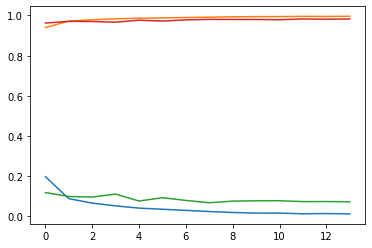

In [141]:
plt.plot(pd.DataFrame(history.history))
plt.show()

### Model Training with Full Dataset 
In this part I will train the model with the full dataset. This time I will use the discovered hyperparameters from previous section.

In [142]:
model_full = create_model_struc()
model_full.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_18 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_19 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
activation_19 (Activation)   (None, 4, 4, 128)        

In [143]:
# creating a new log dir for tensorboard
tensorboard_cb_f = keras.callbacks.TensorBoard(get_run_logdir())
checkpoint_cb_f = keras.callbacks.ModelCheckpoint("my_modell_full.h5", save_best_only=False, save_weights_only=False)

In [144]:
# preparing full features set (X) for the tensorflow data api

training_dataset_all = training_dataset.concatenate(training_crop_dataset)
val_dataset_all = val_dataset.concatenate(val_crop_dataset)

training_ds_all = training_dataset_all.concatenate(val_dataset_all)

training_ds_all = training_ds_all.shuffle(20000).batch(32).prefetch(1)

In [145]:
# Train the model again pleeeeease with all you got .... especially the new transformed data matrix X 
history_full = model_full.fit(training_ds_all, epochs=14, callbacks=[tensorboard_cb_f, checkpoint_cb_f])

Epoch 1/14
2625/2625 [==============================] - 26s 10ms/step - loss: 0.1792 - accuracy: 0.9453
Epoch 2/14
2625/2625 [==============================] - 26s 10ms/step - loss: 0.0815 - accuracy: 0.9746
Epoch 3/14
2625/2625 [==============================] - 26s 10ms/step - loss: 0.0613 - accuracy: 0.9808
Epoch 4/14
2625/2625 [==============================] - 26s 10ms/step - loss: 0.0483 - accuracy: 0.9843
Epoch 5/14
2625/2625 [==============================] - 26s 10ms/step - loss: 0.0395 - accuracy: 0.9873
Epoch 6/14
2625/2625 [==============================] - 27s 10ms/step - loss: 0.0337 - accuracy: 0.9889
Epoch 7/14
2625/2625 [==============================] - 27s 10ms/step - loss: 0.0280 - accuracy: 0.9910
Epoch 8/14
2625/2625 [==============================] - 27s 10ms/step - loss: 0.0234 - accuracy: 0.9921
Epoch 9/14
2625/2625 [==============================] - 27s 10ms/step - loss: 0.0210 - accuracy: 0.9930
Epoch 10/14
2625/2625 [==============================] - 27s 10m

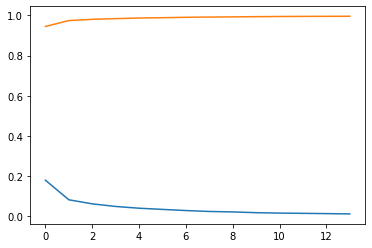

In [146]:
plt.plot(pd.DataFrame(history_full.history))
plt.show()

# Image Prediction of Unknown Data (Test Data)

## Peparing Test Data
As well as previously done, we need to create a TF dataset of the test set as well.

In [147]:
# converting dataframe format into tensorflow compatible format.
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1)


test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test, tf.float32)
        )
    )
)

In [148]:
test_dataset

<TensorSliceDataset shapes: (28, 28, 1), types: tf.float32>

In [149]:
test_ds = test_dataset.batch(32).prefetch(1)

## Creating Competition File

In [150]:
mnist_competition_file = pd.DataFrame(columns=['ImageId','Label'])

## Prediction of Testdata

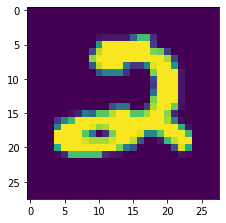

In [151]:
# Visualizing the image
plt.figure(figsize=(12, 12))
for X_batch in test_ds.take(1):
    for index in range(1):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index])

plt.show()

In [152]:
for element in test_ds.take(1):
    print("Propability of all lables for given pixels: ", model_full.predict(test_ds.take(1))[0])

Propability of all lables for given pixels:  [3.6760672e-19 2.7813120e-22 1.0000000e+00 4.9501728e-15 1.5551702e-16
 4.5903582e-19 1.1105674e-20 1.1551887e-16 6.7895241e-18 7.3449477e-19]


In [153]:
print("Predicted Digit: ",np.argmax(model_full.predict(test_ds.take(1))[0]))

Predicted Digit:  2


In [154]:
predictions = model_full.predict(test_ds)                                                                           # predict the probability
predictions = np.argmax(predictions, axis=1)                                                                        # getting the predicted digit numbers based ont the probability of every np element 
mnist_competition_file = pd.DataFrame(predictions)                                                                  # converting into df
mnist_competition_file.index += 1                                                                                   # index should start at 1
mnist_competition_file.reset_index(level=0, inplace=True)                                                           # make the index a column 
mnist_competition_file = mnist_competition_file.rename(columns={"index": "ImageId", 0: "Label"}, errors="raise")    # renamen them according to the competition requirements

In [155]:
mnist_competition_file

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [156]:
mnist_competition_file.ImageId = mnist_competition_file.ImageId.astype(int)
mnist_competition_file.Label = mnist_competition_file.Label.astype(int)

In [157]:
mnist_competition_file.to_csv('mnist_submission.csv', index=False)